# structflo-cser — Quickstart

This notebook walks through the **Chemical Structure + Label Extraction** pipeline
step-by-step, then shows the one-liner convenience API.

**Pipeline stages:**
1. **Detect** — YOLO finds chemical structures and compound labels
2. **Match** — Hungarian algorithm pairs each structure with its nearest label
3. **Extract** — DECIMER converts structure crops → SMILES; EasyOCR reads label text



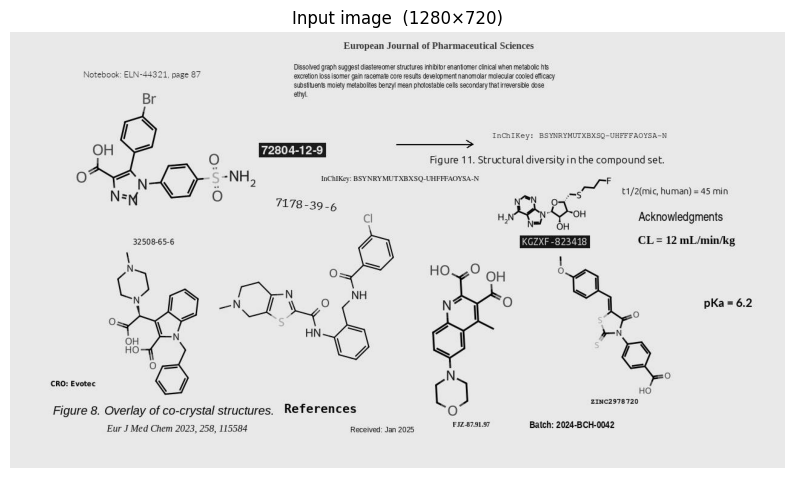

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
from PIL import Image

from structflo.cser.viz import plot_detections, plot_pairs, plot_crops, plot_results

# Choose a test image (change the filename as needed)
IMAGE_PATH = Path("notebook-data/syn-1.jpg")

assert IMAGE_PATH.exists(), f"Image not found: {IMAGE_PATH}"

img = Image.open(IMAGE_PATH).convert("RGB")
plt.figure(figsize=(10, 16))
plt.imshow(img)
plt.axis("off")
plt.title(f"Input image  ({img.width}×{img.height})")
plt.show()

## Part 1 — Step-by-step pipeline

### 1a. Create the pipeline

The pipeline is lazy — YOLO weights, DECIMER, and EasyOCR are only loaded on first use.

In [2]:
from structflo.cser.pipeline import ChemPipeline
from structflo.cser.lps import LearnedMatcher

# Create pipeline — no tiling for this small demo image, match within 500px
pipeline = ChemPipeline(
    weights="../runs/labels_detect/yolo11l_panels/weights/best.pt",
    tile=False,
    conf=0.70,
    matcher=LearnedMatcher(
        weights="../runs/lps/best.pt",
        min_score=0.70
        ),
    )


### 1b. Detect — find structures and labels

`pipeline.detect()` runs YOLO and returns a flat list of `Detection` objects (class 0 = structure, class 1 = label).

In [3]:
detections = pipeline.detect(IMAGE_PATH)

n_struct = sum(1 for d in detections if d.class_id == 0)
n_label  = sum(1 for d in detections if d.class_id == 1)
print(f"Found {n_struct} structures and {n_label} labels  ({len(detections)} total detections)")

Found 6 structures and 6 labels  (12 total detections)


### Visualise detections

Green = chemical structure, Blue = compound label.

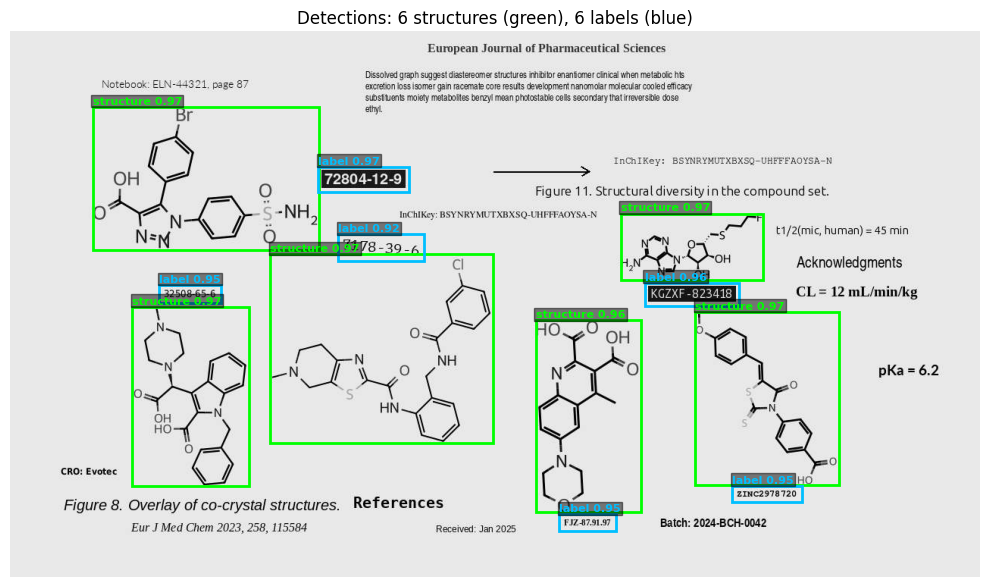

In [4]:
fig = plot_detections(img, detections)
plt.show()

### 1c. Match — pair structures with labels

`pipeline.match()` uses the Hungarian algorithm to optimally pair each structure with its nearest label by centroid distance.

In [5]:
pairs = pipeline.match(detections, image=img)
print(f"Matched {len(pairs)} structure–label pairs\n")

for i, p in enumerate(pairs):
    sc = p.structure.bbox.centroid
    lc = p.label.bbox.centroid
    print(f"  Pair {i}: confidence={p.match_confidence:.2f}  "
          f"structure@({sc[0]:.0f},{sc[1]:.0f})  label@({lc[0]:.0f},{lc[1]:.0f})")

Matched 6 structure–label pairs

  Pair 0: confidence=1.00  structure@(999,484)  label@(998,610)
  Pair 1: confidence=1.00  structure@(258,194)  label@(466,195)
  Pair 2: confidence=0.94  structure@(238,481)  label@(237,346)
  Pair 3: confidence=0.99  structure@(490,418)  label@(490,285)
  Pair 4: confidence=1.00  structure@(899,284)  label@(900,346)
  Pair 5: confidence=1.00  structure@(763,507)  label@(762,648)


### Visualise matched pairs

Orange lines connect each structure to its matched label.

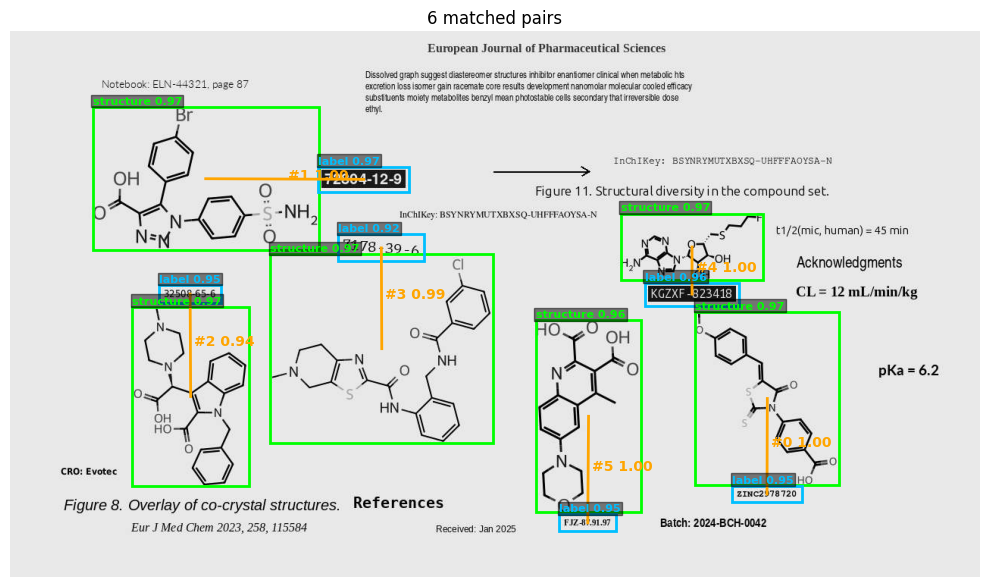

In [6]:
fig = plot_pairs(img, pairs)
plt.show()

### 1d. Show cropped regions for each pair

For each matched pair, we crop the structure and label regions from the original image.

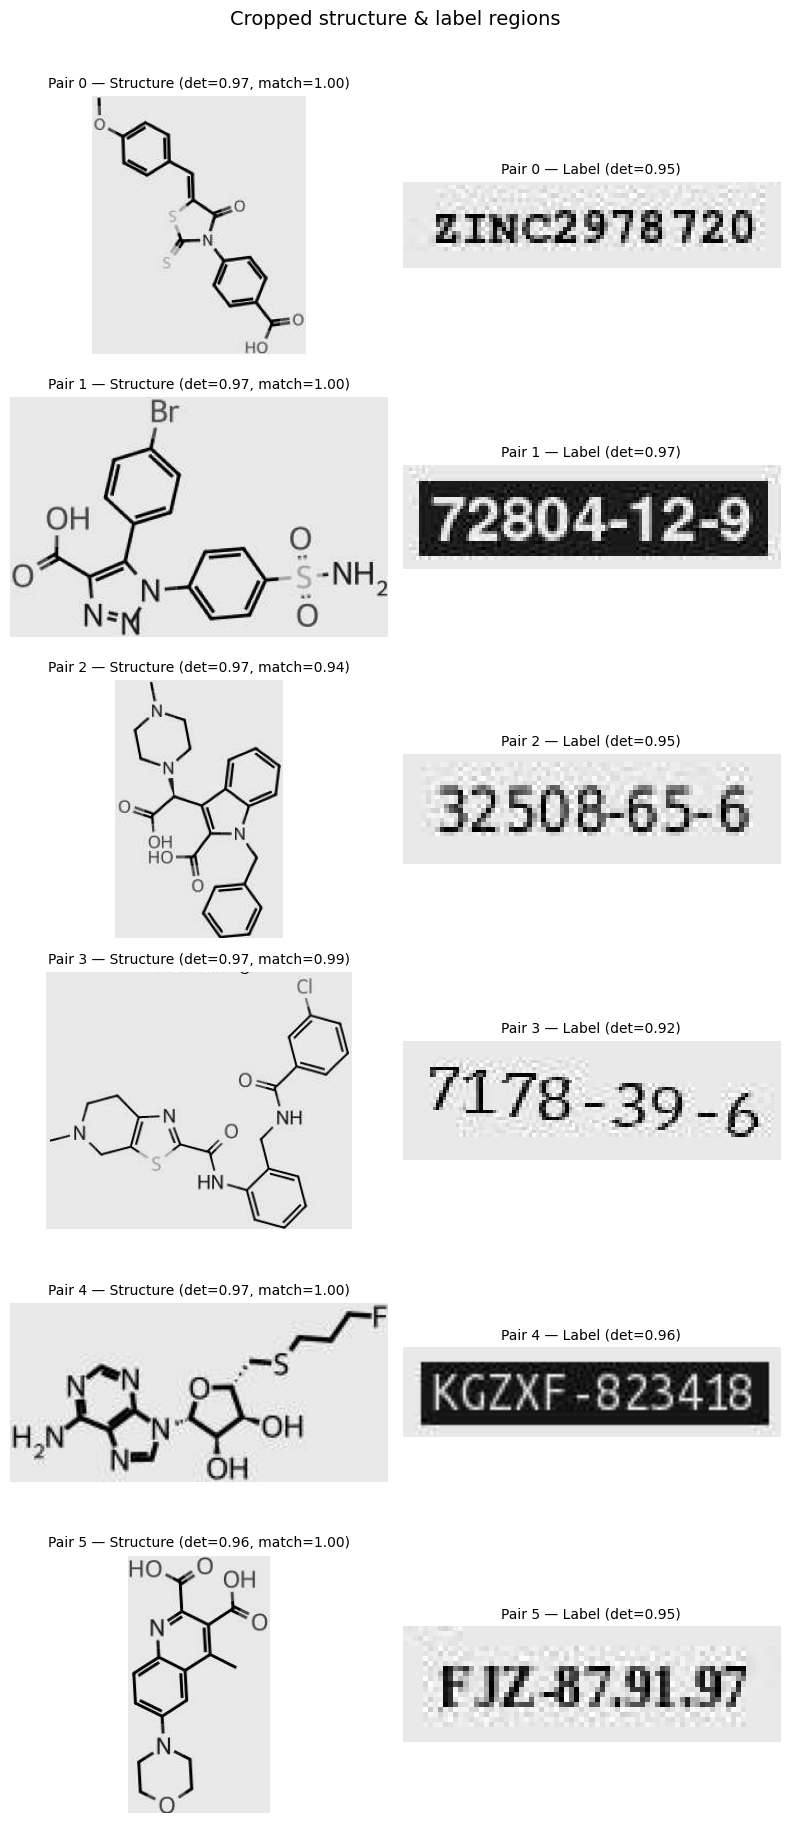

In [7]:
fig = plot_crops(img, pairs)
plt.show()

### 1e. Extract — SMILES and label text

`pipeline.enrich()` runs DECIMER on each structure crop and EasyOCR on each label crop, populating `pair.smiles` and `pair.label_text`.

In [16]:
enriched_pairs = pipeline.enrich(pairs, IMAGE_PATH)

for i, p in enumerate(enriched_pairs):
    print(f"Pair {i}:")
    print(f"  SMILES:     {p.smiles}")
    print(f"  Label text: {p.label_text}")
    print(f"  Confidence:   {p.match_confidence:.2f}")
    print()

Pair 0:
  SMILES:     COC1=CC=C(C=C1)C=C2C(=O)N(C3=CC=C(C=C3)C(=O)O)C(=S)S2
  Label text: ZINC2978 720
  Confidence:   1.00

Pair 1:
  SMILES:     C1=CC(=CC=C1C2=C(C(=O)O)N=NN2C3=CC=C(C=C3)S(=O)(=O)N)Br
  Label text: 772804-12-9
  Confidence:   1.00

Pair 2:
  SMILES:     CN1CCN(CC1)[C@@H](C2=C(C(=O)O)N(CC3=CC=CC=C3)C4=CC=CC=C42)C(=O)O
  Label text: 32508-65-6
  Confidence:   0.94

Pair 3:
  SMILES:     CN1CCC2=C(C1)SC(=N2)C(=O)NC3=C(C=CC=C3)CNC(=O)C4=CC=CC(=C4)Cl.[Y]
  Label text: 7178-39-6
  Confidence:   0.99

Pair 4:
  SMILES:     C(CF)CSC[C@@H]1[C@H]([C@H]([C@H](N2C=NC3=C2N=CN=C3N)O1)O)O
  Label text: KGZXF -823418
  Confidence:   1.00

Pair 5:
  SMILES:     CC1=C(C(=NC2=CC=C(C=C12)N3CCOCC3)C(=O)O)C(=O)O
  Label text: FJZ 87.91.97
  Confidence:   1.00



### 1f. Results as a DataFrame

In [17]:
df = ChemPipeline.to_dataframe(enriched_pairs)
df

,structure_bbox,structure_conf,label_bbox,label_conf,match_distance,match_confidence,smiles,label_text
0,"[903.927490234375, 369.34625244140625, 1093.77...",0.9720,"[952.4268188476562, 599.1146240234375, 1044.46...",0.9499,0.00,0.9993,COC1=CC=C(C=C1)C=C2C(=O)N(C3=CC=C(C=C3)C(=O)O)...,ZINC2978 720
1,"[108.74571990966797, 99.40966796875, 406.75408...",0.9707,"[406.0760498046875, 178.16525268554688, 526.34...",0.9661,0.00,1.0000,C1=CC(=CC=C1C2=C(C(=O)O)N=NN2C3=CC=C(C=C3)S(=O...,772804-12-9
2,"[160.89210510253906, 362.9150390625, 314.92996...",0.9691,"[196.05369567871094, 334.19195556640625, 278.3...",0.9490,0.06,0.9350,CN1CCN(CC1)[C@@H](C2=C(C(=O)O)N(CC3=CC=CC=C3)C...,32508-65-6
3,"[342.84368896484375, 293.84014892578125, 637.3...",0.9680,"[432.8483581542969, 267.3332214355469, 546.166...",0.9245,0.01,0.9899,CN1CCC2=C(C1)SC(=N2)C(=O)NC3=C(C=CC=C3)CNC(=O)...,7178-39-6
4,"[805.4283447265625, 239.84451293945312, 993.56...",0.9680,"[836.924560546875, 331.1330871582031, 962.1223...",0.9632,0.00,0.9998,C(CF)CSC[C@@H]1[C@H]([C@H]([C@H](N2C=NC3=C2N=C...,KGZXF -823418
5,"[693.270263671875, 380.87432861328125, 832.620...",0.9578,"[724.2113037109375, 636.9132080078125, 799.658...",0.9467,0.00,0.9996,CC1=C(C(=NC2=CC=C(C=C12)N3CCOCC3)C(=O)O)C(=O)O,FJZ 87.91.97


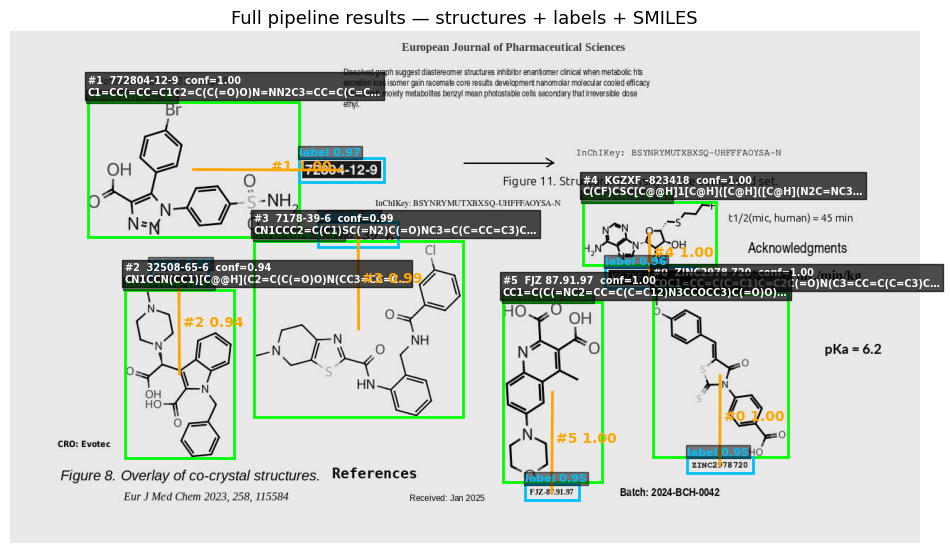

In [10]:
fig = plot_results(img, enriched_pairs)
plt.show()

---

## Part 2 — Full pipeline in one call

Everything above (detect → match → enrich) can be done in a single `process()` call.

In [11]:
from structflo.cser.pipeline import ChemPipeline
from structflo.cser.lps import LearnedMatcher

# Create pipeline
pipeline = ChemPipeline(
    tile=False,
    conf=0.70,
    matcher=LearnedMatcher(
        weights="../runs/lps/best.pt",
        min_score=0.70
        ),
)

In [12]:
# One-liner: detect + match + extract SMILES & OCR in a single call
results = pipeline.process(IMAGE_PATH)

# View as DataFrame
ChemPipeline.to_dataframe(results)

,structure_bbox,structure_conf,label_bbox,label_conf,match_distance,match_confidence,smiles,label_text
0,"[343.3332824707031, 298.47149658203125, 635.89...",0.9573,"[432.1730041503906, 267.5862121582031, 546.668...",0.9219,0.02,0.9844,CN1CCC2=C(C1)SC(=N2)C(=O)NC3=C(C=CC=C3)CNC(=O)...,7178-39-6
1,"[108.32279205322266, 99.74943542480469, 406.93...",0.9572,"[405.439208984375, 177.31838989257812, 526.623...",0.9373,0.00,0.9973,C1=CC(=CC=C1C2=C(C(=O)O)N=NN2C3=CC=C(C=C3)S(=O...,72804-12-9
2,"[904.202392578125, 369.7506408691406, 1091.622...",0.9563,"[952.1218872070312, 598.8056640625, 1045.03320...",0.9263,0.00,0.9997,COC1=CC=C(C=C1)C=C2C(=O)N(C3=CC=C(C=C3)C(=O)O)...,ZINC2978 720
3,"[161.93466186523438, 363.0390930175781, 313.34...",0.9547,"[195.62179565429688, 333.852783203125, 278.739...",0.9185,0.04,0.9587,CN1CCN(CC1)[C@@H](C2=C(C(=O)O)N(CC3=CC=CC=C3)C...,32508-65-6
4,"[806.03076171875, 240.70889282226562, 992.5532...",0.9537,"[837.0864868164062, 330.5846862792969, 962.476...",0.9337,0.00,0.9997,C(CF)CSC[C@@H]1[C@H]([C@H]([C@H](N2C=NC3=C2N=C...,KGZXF -823418
5,"[693.6105346679688, 382.15234375, 830.99865722...",0.9514,"[723.584716796875, 636.6728515625, 799.9077148...",0.9216,0.00,0.9994,CC1=C(C(=NC2=CC=C(C=C12)N3CCOCC3)C(=O)O)C(=O)O,"FJZ 87.91,97"


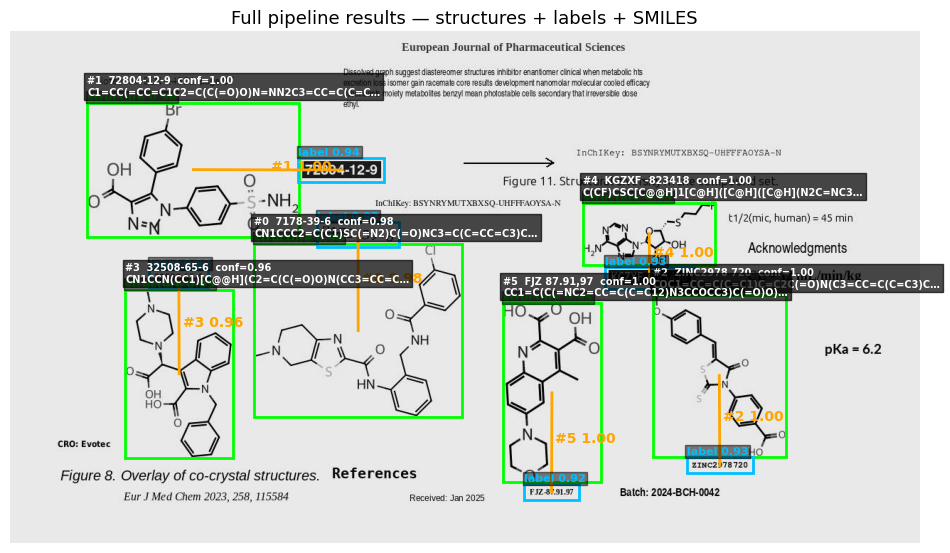

In [13]:
fig = plot_results(img, results)
plt.show()

### Export to JSON

In [14]:
print(ChemPipeline.to_json(results))

[
  {
    "structure_bbox": [
      343.3332824707031,
      298.47149658203125,
      635.892578125,
      542.6845703125
    ],
    "structure_conf": 0.9573,
    "label_bbox": [
      432.1730041503906,
      267.5862121582031,
      546.6683959960938,
      303.18402099609375
    ],
    "label_conf": 0.9219,
    "match_distance": 0.02,
    "match_confidence": 0.9844,
    "smiles": "CN1CCC2=C(C1)SC(=N2)C(=O)NC3=C(C=CC=C3)CNC(=O)C4=CC=CC(=C4)Cl",
    "label_text": "7178-39-6"
  },
  {
    "structure_bbox": [
      108.32279205322266,
      99.74943542480469,
      406.9380187988281,
      288.082763671875
    ],
    "structure_conf": 0.9572,
    "label_bbox": [
      405.439208984375,
      177.31838989257812,
      526.623779296875,
      211.6856689453125
    ],
    "label_conf": 0.9373,
    "match_distance": 0.0,
    "match_confidence": 0.9973,
    "smiles": "C1=CC(=CC=C1C2=C(C(=O)O)N=NN2C3=CC=C(C=C3)S(=O)(=O)N)Br",
    "label_text": "72804-12-9"
  },
  {
    "structure_bbox": [
  